4.4.2 평균-분산 포트폴리오 이론
- 다음 파이선 코드는 역사적 가격 데이터를 가져와 투자자가 목표로 하는 주식코드를 선택하고 가격 시계열 데이터의 로그 주식률을 계산한다.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB


<Axes: title={'center': 'Normalized Price Series'}, xlabel='Date'>

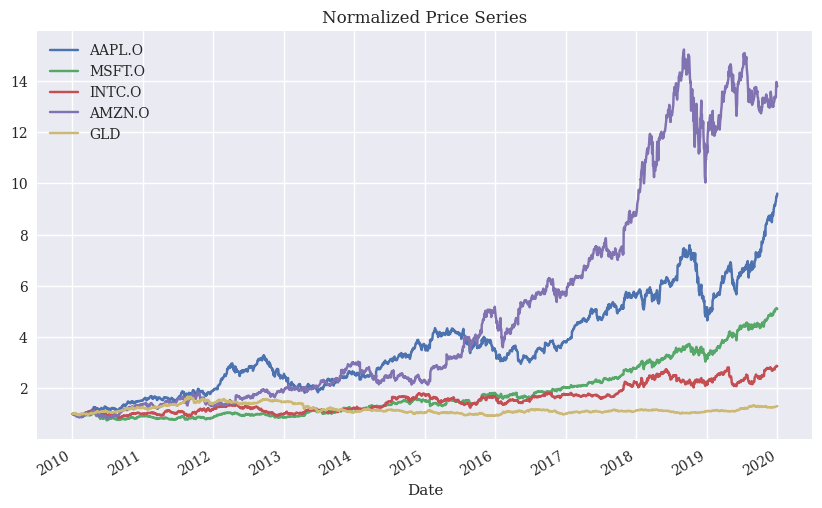

In [1]:
import numpy as np
import pandas as pd
from pylab import plt, mpl
from scipy.optimize import minimize

plt.style.use("seaborn-v0_8")
mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["font.family"] = "serif"
np.set_printoptions(precision=5, suppress=True, formatter={"float": lambda x: f"{x:6.3f}"})

# 역사적 일간 데이터를 가져온다
url = "http://hilpisch.com/aiif_eikon_eod_data.csv" 
raw = pd.read_csv(url, index_col=0, parse_dates=True).dropna()
raw.info()

# 투자할 종목 코드를 표시한다.
symbols = ["AAPL.O", "MSFT.O", "INTC.O", "AMZN.O", "GLD"]

# 모든 시계열에 대해 로그 수익률을 계산한다.
rets = np.log(raw[symbols] / raw[symbols].shift(1)).dropna()

# 선택된 종목 코드에 대한 정규화된 시계열을 그린다.
(raw[symbols] / raw[symbols].iloc[0]).plot(figsize=(10, 6), title="Normalized Price Series")


- 데이터 기반 투자는 우선 전체 기간 데이터를 사용하여 동일 가중 포트폴리오의 성능을 기준성능으로 포트폴리오 수익률과 변동성과 샤프비율을 계산하는 종목 코드를 만든다.

In [2]:
# 동일 가중 포트폴리오
weights = len(rets.columns) * [1 / len(rets.columns)]

# 포트폴리오 수익률
def port_return(rets, weights):
    return np.dot(rets.mean(), weights) * 252  # 연간화

print("수익률:", port_return(rets, weights))

# 포트폴리오 변동성
def port_volatility(rets, weights):
    return np.dot(weights, np.dot(rets.cov() * 252, weights)) ** 0.5  # 연간화

print("변동성:", port_volatility(rets, weights))


# 포트폴리오 샤프 비율
def port_shape(rets, weights):
    return port_return(rets, weights) / port_volatility(rets, weights)

print("샤프 비율:", port_shape(rets, weights))

수익률: 0.156947646530181
변동성: 0.16106507848480675
샤프 비율: 0.9744362217225496


- 또한 투자자는 몬테카를로 시뮬레이션을 통해 무작위 포트폴리오 가중치를 여러개 생성하여, 그에 따른 포트폴리오 수익률과 리스크, 그리고 샤프 비율을 분석하길 원한다.

[[ 0.155  0.267  0.211  0.252  0.115]
 [ 0.261  0.265  0.323  0.099  0.052]
 [ 0.136  0.160  0.121  0.296  0.287]
 [ 0.267  0.070  0.321  0.211  0.131]
 [ 0.082  0.171  0.001  0.269  0.477]]


Text(0.5, 1.0, 'AAPL.O | MSFT.O | INTC.O | AMZN.O | GLD')

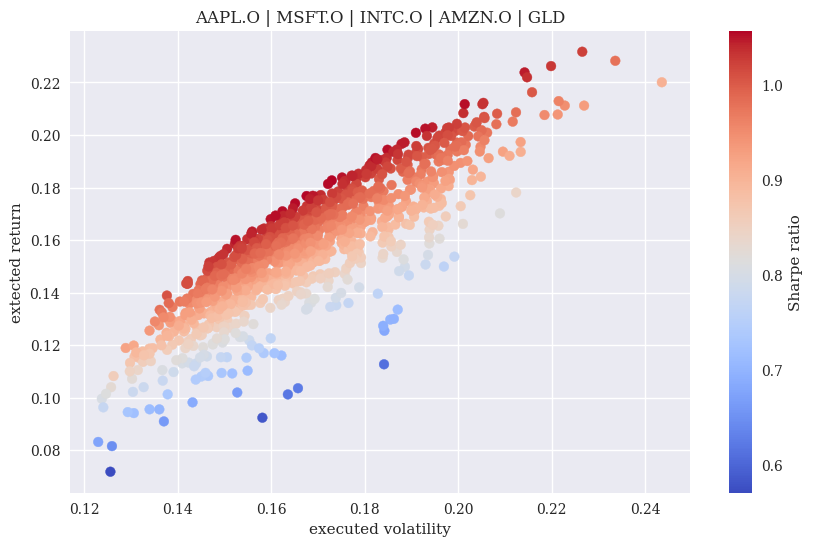

In [3]:
# 100%를 채운 포트폴리오 가중치를 시물레이션
w = np.random.random((1000, len(rets.columns)))
w = (w.T / w.sum(axis=1)).T 
print(w[:5])

# 해당 포트폴리오의 수익률과 변동성 계산
pvr = [(port_volatility(rets[symbols], weights),
        port_return(rets[symbols], weights))
        for weights in w]
pvr = np.array(pvr)

# 샤프비율계산
psr = pvr[:,1] / pvr[:,0]

# 샤프비율을 색온도로 그래프 생성
plt.figure(figsize=(10, 6))
fig = plt.scatter(pvr[:,0], pvr[:,1], c=psr, cmap="coolwarm")
cb = plt.colorbar(fig)
cb.set_label("Sharpe ratio")
plt.xlabel("executed volatility")
plt.ylabel("extected return")
plt.title(" | ".join(symbols))

- 2011년 초 시점으로 포트폴리오의 성능을 백테스트하기
  - 2011년초에 사용할 최적의 포트폴리오 구성은 2010년 시계열 데이터를 기반으로 계산한다.
  - 마찬가지로 2012년초의 포트폴리오 구성은 2011년의 데이터로 만든다. 

In [4]:
""" 샤프 비율을 최대화하는 각 연도의 포트폴리오 가중치를 구한다. """
# 1. 단일 주식의 가중치 한계를 설정
bnds = len(symbols) * [(0, 1),]
print("가중치 한계:", bnds)

# 2. 모든 가중치의 합이 100%가 되도록 설정
cons = {"type": "eq", "fun": lambda weights: weights.sum() - 1}
opt_weights = {}

# 3. 해당 연도의 데이터를 선택
for year in range(2010, 2019):
    rets_ = rets[symbols].loc[f"{year}-01-01":f"{year}-12-31"]

# 4. 샤프 비율이 최대화되는 포트폴리오 가중치 계산
    ow = minimize(lambda weights: -port_shape(rets_, weights),
                  len(symbols) * [1 / len(symbols)],
                  bounds = bnds,
                  constraints = cons)["x"]
    opt_weights[year] = ow

# 5. 계산된 가중치
print("연도별 최적화된 가중치:", opt_weights)


가중치 한계: [(0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]
연도별 최적화된 가중치: {2010: array([ 0.366,  0.000,  0.000,  0.056,  0.578]), 2011: array([ 0.543,  0.000,  0.077,  0.000,  0.380]), 2012: array([ 0.324,  0.000,  0.000,  0.471,  0.205]), 2013: array([ 0.012,  0.305,  0.219,  0.464,  0.000]), 2014: array([ 0.452,  0.115,  0.419,  0.000,  0.015]), 2015: array([ 0.000,  0.000,  0.000,  1.000,  0.000]), 2016: array([ 0.150,  0.260,  0.000,  0.058,  0.533]), 2017: array([ 0.231,  0.203,  0.031,  0.109,  0.426]), 2018: array([ 0.000,  0.295,  0.000,  0.705,  0.000])}


- 백테스팅 결과를 완성하기 위해 다음 코드로 전년도 실현 데이터로 계산한 포트폴리오 기대 수익률과 실제 데이터로 계산한 포트폴리오 실현 수익률을 비교

In [5]:
res = pd.DataFrame()
for year in range(2010, 2019):
    # 기대 포트폴리오 통계
    rets_ = rets[symbols].loc[f"{year}-01-01":f"{year}-12-31"]
    epv = port_volatility(rets_, opt_weights[year])
    epr = port_return(rets_, opt_weights[year])
    esr = epr / epv 
    
    # 실제 포트폴리오 통계
    rets_ = rets[symbols].loc[f"{year+1}-01-01":f"{year+1}-12-31"]
    rpv = port_volatility(rets_, opt_weights[year])
    rpr = port_return(rets_, opt_weights[year])
    rsr = rpr / rpv
    
    res = pd.concat([res, pd.DataFrame({"epv": epv, "epr": epr , "esr": esr,
                                       "rpv": rpv, "rpr": rpr, "rsr": rsr},
                                      index=[year+1])])
    
print(res)

print(res.mean())

           epv       epr       esr       rpv       rpr       rsr
2011  0.157440  0.303003  1.924564  0.160622  0.133836  0.833235
2012  0.173279  0.169321  0.977156  0.182292  0.161375  0.885256
2013  0.202460  0.278459  1.375378  0.168714  0.166897  0.989228
2014  0.181544  0.368961  2.032353  0.197798  0.026830  0.135645
2015  0.160340  0.309486  1.930190  0.211368 -0.024560 -0.116194
2016  0.326730  0.778330  2.382179  0.296565  0.103870  0.350242
2017  0.106148  0.090933  0.856663  0.079521  0.230630  2.900235
2018  0.086548  0.260702  3.012226  0.157337  0.038234  0.243004
2019  0.323796  0.228008  0.704174  0.207672  0.275819  1.328147
epv    0.190920
epr    0.309689
esr    1.688320
rpv    0.184654
rpr    0.123659
rsr    0.838755
dtype: float64


- 평균-분산 포트폴리오 이론은 포트폴리오 '변동성'을 예측하는 데에는 좋은 성능을 보인다.
  - 이는 두 시계열의 높은 상관관계로 증명된다.

,epv,rpv
epv,1.000000,0.765733
rpv,0.765733,1.000000


<Axes: title={'center': 'Expected vs. Realized Volatility'}>

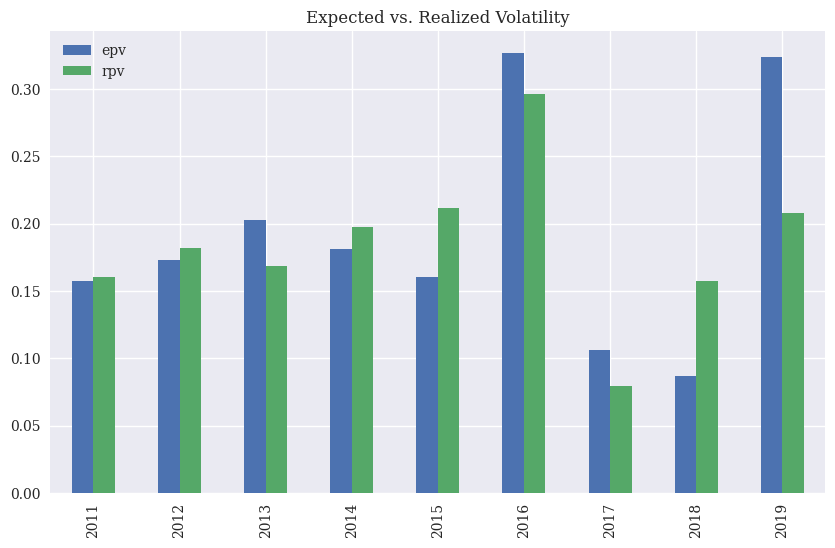

In [6]:
display(res[["epv", "rpv"]].corr())
res[["epv","rpv"]].plot(kind="bar", figsize=(10,6), title="Expected vs. Realized Volatility")

- 하지만, 기대 수익률과 실현 수익률의 경우에는 반대의 결과가 나온다.

,esr,rsr
esr,1.000000,-0.698607
rsr,-0.698607,1.000000


<Axes: title={'center': 'Expected vs. Realized PSharpe Ratio'}>

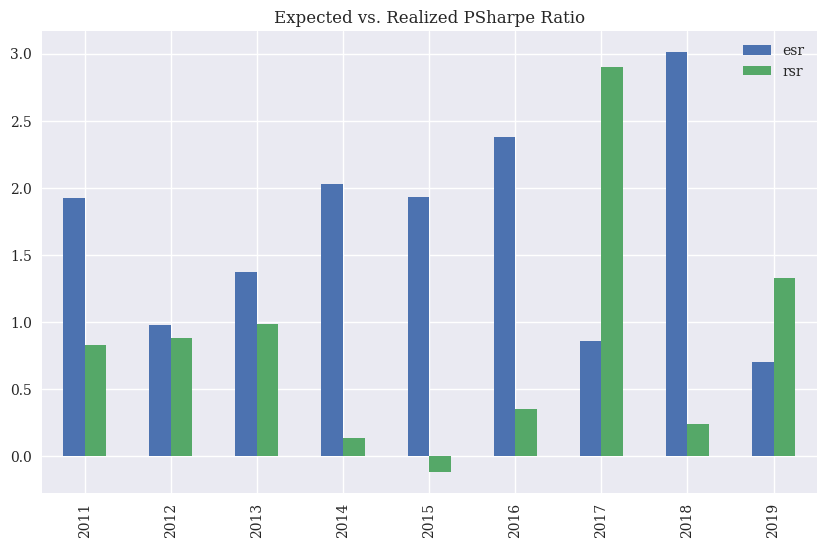

In [7]:
display(res[["esr", "rsr"]].corr())
res[["esr","rsr"]].plot(kind="bar", figsize=(10,6), title="Expected vs. Realized PSharpe Ratio")

** 자본자산 가격결정 모형
- 4개의 기술주에 대한 기대 수익률을 자본자산 가격결정 모형으로 계산
  - 주어진 해에 대한 모든 주식의 베타를 결정하고
  - 그 다음 해의 주식 기대 수익률은 주어진 베타와 시장 포트폴리오의 성능을 이용하여 계산한다.

In [8]:
r = 0.005 # 무위험 단기 이자율 설정
market = ".SPX" # 시장 포트폴리오 정의

rets = np.log(raw / raw.shift(1)).dropna() # 시장의 로그 수익률 계산
res = pd.DataFrame()
for sym in rets.columns[:4]: # 종목별 수익률 계산
    print("\n", sym)
    print(54 * "=")
    for year in range(2010, 2019):
        rets_ = rets.loc[f"{year}-01-01":f"{year}-12-31"]
        muM = rets_[market].mean() * 252 # annualized mean return of the market portfolio
        
        # 개별 주식의 베타 계산
        cov = rets_.cov().loc[sym, market] # 자산과 시장 사이의 공분산 (두 변수간의 상관관계와 방향성)
        var = rets_[market].var() # 시장의 분산을 의미하며, 시장의 변동성을 측정하는 값
        beta = cov / var # 베타 값이 1이면 시장과 동일한 변동성
                         # 1보다 크면 더 큰변동성 (공격적 투자성향)
                         # 1보다 작으면 시장보다 변동성이 낮아 안정적인 자산
                         # 베타가 음수면 시장과 반대 방향
                         
        rets_ = rets.loc[f"{year+1}-01-01":f"{year+1}-12-31"]
        muM = rets_[market].mean() * 252  # 다음 해의 시장 수익률
        mu_capm = r + beta * (muM - r)    # 전년도 베타와 현재 연도의 시장 기대 수익률에서 개별 주식의 수익률 계산
        mu_real = rets_[sym].mean() * 252 # 포트폴리오의 실제 성능
        
        # 모든 결과 수집 및 출력
        res = pd.concat([res, pd.DataFrame({"symbol": sym, "mu_capm": mu_capm, 
                            "mu_real": mu_real, "beta": beta}, 
                           index=[year+1])])
        print("{} | beta: {:.3f} | mu_capm: {:6.3f} | mu_real: {:6.3f}".format(year+1, beta, mu_capm, mu_real))
        


 AAPL.O
2011 | beta: 1.052 | mu_capm: -0.000 | mu_real:  0.228
2012 | beta: 0.764 | mu_capm:  0.098 | mu_real:  0.275
2013 | beta: 1.266 | mu_capm:  0.327 | mu_real:  0.053
2014 | beta: 0.630 | mu_capm:  0.070 | mu_real:  0.320
2015 | beta: 0.833 | mu_capm: -0.005 | mu_real: -0.047
2016 | beta: 1.144 | mu_capm:  0.103 | mu_real:  0.096
2017 | beta: 1.009 | mu_capm:  0.180 | mu_real:  0.381
2018 | beta: 1.379 | mu_capm: -0.091 | mu_real: -0.071
2019 | beta: 1.252 | mu_capm:  0.316 | mu_real:  0.621

 MSFT.O
2011 | beta: 0.890 | mu_capm:  0.001 | mu_real: -0.072
2012 | beta: 0.816 | mu_capm:  0.104 | mu_real:  0.029
2013 | beta: 1.109 | mu_capm:  0.287 | mu_real:  0.337
2014 | beta: 0.876 | mu_capm:  0.095 | mu_real:  0.216
2015 | beta: 0.955 | mu_capm: -0.007 | mu_real:  0.178
2016 | beta: 1.249 | mu_capm:  0.113 | mu_real:  0.113
2017 | beta: 1.224 | mu_capm:  0.217 | mu_real:  0.321
2018 | beta: 1.303 | mu_capm: -0.086 | mu_real:  0.172
2019 | beta: 1.442 | mu_capm:  0.364 | mu_real:

<Axes: title={'center': 'AMZN.O'}>

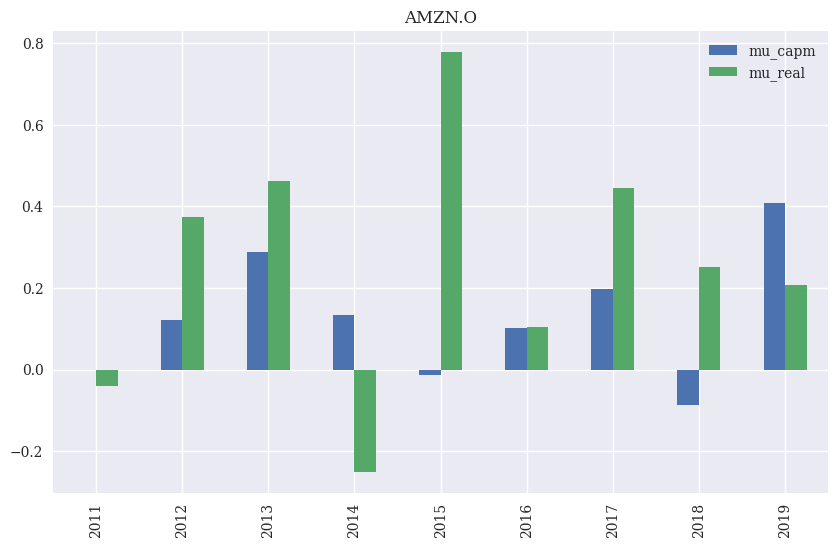

In [9]:
""" 전년도의 베타 및 올해의 시장 포트폴리오 성능을 감안할 때, 단일 종목의 기대 수익률과 실현 수익률을 비교한다. """

sym = str("AMZN.O")
res[res["symbol"] == sym][["mu_capm", "mu_real"]].corr()
res[res["symbol"] == sym][["mu_capm", "mu_real"]].plot(kind="bar", figsize=(10,6), title=sym)

** 차익거래 가격결정 이론
- 투자자들은 주식 수익률을 예측할 수 있는 세 가지 요소를 시장 포트폴리오에 추가한다.
  - (VIX 지수로 표현되는) 시장변동성: .VIX
  - (EUR/USD 환율로 표현되는) 환율: EUR=
  - (금 가격으로 표현되는) 원자재 가격: XAU=

In [10]:
""" 4개의 factor 을 사용한 다변량 회귀분석으로 주식의 미래 성능을 설명하는 
    단순 차익거래 가격결정 이론 접근 방식을 구현한다. """

# 4개의 factor
factors = [".SPX", ".VIX", "EUR=", "XAU="]

res = pd.DataFrame()
np.set_printoptions(formatter={"float": lambda x: f"{x:5.2f}"})

for sym in rets.columns[:4]: # (['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O']
    print("\n" + sym)
    print(71 * "=")
    for year in range(2010, 2019):
        rets_ = rets.loc[f"{year}-01-01":f"{year}-12-31"]
        reg = np.linalg.lstsq(rets_[factors], rets_[sym], rcond=-1)[0]  # 최소제곱법을 사용한 다변량 회귀분석
        rets_ = rets.loc[f"{year+1}-01-01":f"{year+1}-12-31"]
        mu_apt = np.dot(rets_[factors].mean() * 252, reg) # 차익거래 가격결정 모형으로 예측한 주식 수익률
        mu_real = rets_[sym].mean() * 252 # 주식의 실현 수익률
        res = pd.concat([res, pd.DataFrame({"symbol": sym, "mu_apt": mu_apt, "mu_real": mu_real},
                           index=[year+1])])
        print("{} | fl: {} | mu_apt: {:6.3f} | mu_real: {:6.3f}".format(year+1, reg, mu_apt, mu_real))


AAPL.O
2011 | fl: [ 0.91 -0.04 -0.35  0.12] | mu_apt:  0.011 | mu_real:  0.228
2012 | fl: [ 0.76 -0.02 -0.24  0.05] | mu_apt:  0.099 | mu_real:  0.275
2013 | fl: [ 1.67  0.04 -0.56  0.10] | mu_apt:  0.366 | mu_real:  0.053
2014 | fl: [ 0.53 -0.00  0.02  0.16] | mu_apt:  0.050 | mu_real:  0.320
2015 | fl: [ 1.07  0.02  0.25  0.01] | mu_apt: -0.038 | mu_real: -0.047
2016 | fl: [ 1.21  0.01 -0.14 -0.02] | mu_apt:  0.110 | mu_real:  0.096
2017 | fl: [ 1.10  0.01 -0.15 -0.02] | mu_apt:  0.170 | mu_real:  0.381
2018 | fl: [ 1.06 -0.03 -0.15  0.12] | mu_apt: -0.088 | mu_real: -0.071
2019 | fl: [ 1.37  0.01 -0.20  0.13] | mu_apt:  0.364 | mu_real:  0.621

MSFT.O
2011 | fl: [ 0.98  0.01  0.02 -0.11] | mu_apt: -0.008 | mu_real: -0.072
2012 | fl: [ 0.82  0.00 -0.03 -0.01] | mu_apt:  0.103 | mu_real:  0.029
2013 | fl: [ 1.14  0.00 -0.07 -0.01] | mu_apt:  0.294 | mu_real:  0.337
2014 | fl: [ 1.28  0.05  0.04  0.07] | mu_apt:  0.149 | mu_real:  0.216
2015 | fl: [ 1.20  0.03  0.05  0.01] | mu_apt: -

* 다음은 차익거래 가격결정 모형이 예상한 주식 수익률과 시간이 지남에 따라 실현된 주식 수익률 비교를 나타낸다
  - 단일 요인 자본자산 가격결정 모형과 비교하면 거의 개선되지 않은 것으로 보인다.

,mu_apt,mu_real
mu_apt,1.000000,-0.098281
mu_real,-0.098281,1.000000


<Axes: title={'center': 'AMZN.O'}>

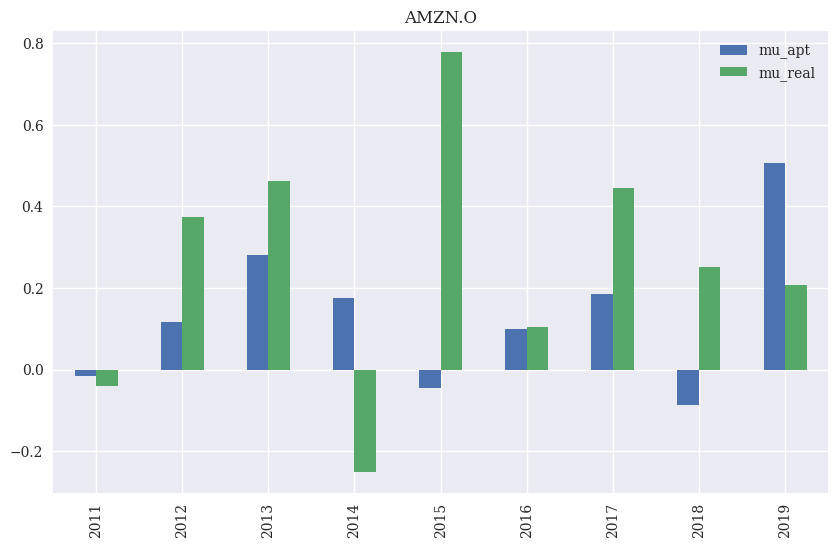

In [11]:
sym = "AMZN.O"
display(res[res["symbol"] == sym][["mu_apt", "mu_real"]].corr())
res[res["symbol"] == sym].plot(kind="bar", figsize=(10,6), title=sym)

여러가지 주식의 평균값을 비교해보자. 
- 평균적인 차익거래 가격결정 모형에서 변화된 부분이 거의 없으며 실현 수익률과 큰 차이를 보인다.
- 물론 어떤 리스크 요인을 선택하는지가 가장 중요하다.
  - 투자자들이 선택한 요인들: Market, Size, Volatility, Value, Risk, Growth, Momentum

,mu_apt,mu_real
symbol,,
AAPL.O,0.116116,0.206158
AMZN.O,0.135528,0.259395
INTC.O,0.124811,0.116180
MSFT.O,0.128441,0.192655


<Axes: title={'center': 'Average Values'}, xlabel='symbol'>

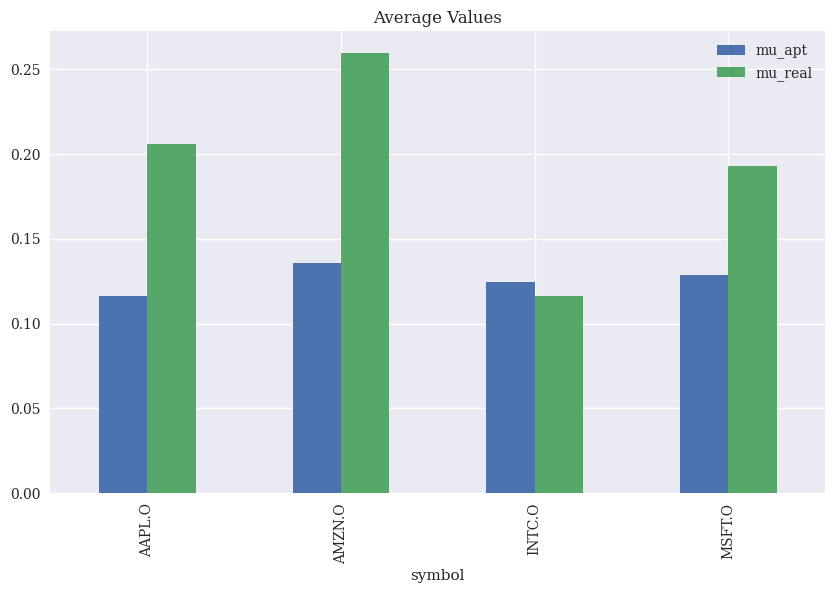

In [12]:
grouped = res.groupby("symbol").mean()
display(grouped)
grouped.plot(kind="bar", figsize=(10,6), title="Average Values")

저자의 웹사이트에 저장된 factor data를 사용하여 확인해보자

<Axes: title={'center': 'Normalized Factor Series'}, xlabel='Date'>

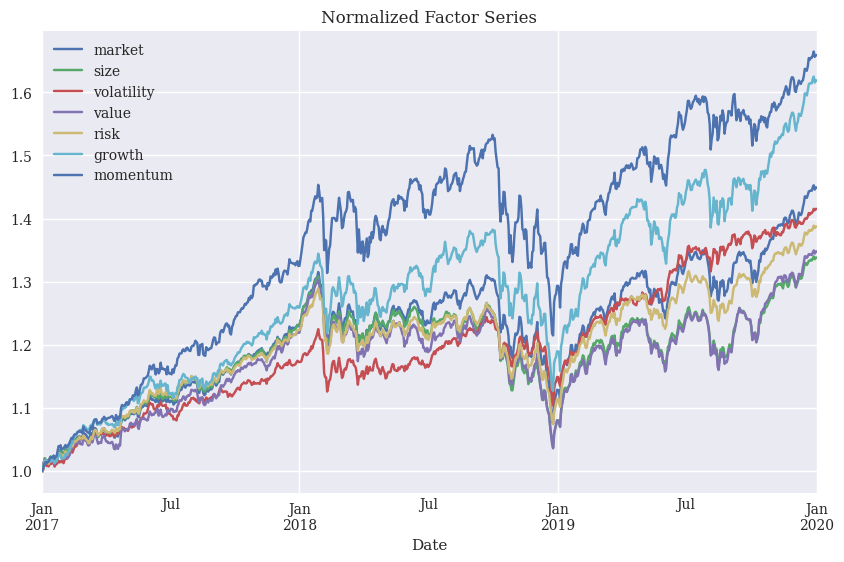

In [13]:
# 리스크 요인 시계열 데이터 가져오기
factors = pd.read_csv("http://hilpisch.com/aiif_eikon_eod_factors.csv", index_col=0, parse_dates=True)
# factors.info()

# 정규화 및 시각화
(factors / factors.iloc[0]).plot(figsize=(10, 6), title="Normalized Factor Series")

factor 간의 상관관계를 구해보자

In [14]:
# 시작일과 종료일
start = "2017-01-01"
end = "2020-01-01"

# 관련 데이터 선택
retsd = rets.loc[start:end].copy()
retsd.dropna(inplace=True)

# factor의 로그 수익률 계산 및 처리
retsf = np.log(factors / factors.shift(1))
retsf = retsf.loc[start:end]
retsf.dropna(inplace=True)
retsf = retsf.loc[retsd.index].dropna()

# factor의 상관관계 행렬
retsf.corr()

,market,size,volatility,value,risk,growth,momentum
market,1.000000,0.935867,0.845010,0.964124,0.947150,0.959038,0.928705
size,0.935867,1.000000,0.791767,0.965739,0.983238,0.835477,0.796420
volatility,0.845010,0.791767,1.000000,0.778294,0.865467,0.818280,0.819585
value,0.964124,0.965739,0.778294,1.000000,0.958359,0.864222,0.818796
risk,0.947150,0.983238,0.865467,0.958359,1.000000,0.858546,0.825563
growth,0.959038,0.835477,0.818280,0.864222,0.858546,1.000000,0.952956
momentum,0.928705,0.796420,0.819585,0.818796,0.825563,0.952956,1.000000


새로운 요인들을 사용해서 요인계수를 도출한다.
- 데이터의 절반을 사용해서 요인계수를 계산하며, 나머지 데이터는 주식 수익률을 예측하는 데 사용한다.
- 실현 수익률도 계산한다.

(요인들의 상관관계가 높기 떄문에 차익거래 가격결정 모형의 설명도 자본자산 가격결정 모형에 비해 그다지 높지 않다.)


AAPL.O
fl: [ 2.30  2.80 -0.70 -1.40 -4.20  2.00 -0.20] | apt: 0.115 | real: 0.301

MSFT.O
fl: [ 1.50  0.00  0.10 -1.30 -1.40  0.80  1.00] | apt: 0.181 | real: 0.304

INTC.O
fl: [-3.10  1.60  0.40  1.30 -2.60  2.50  1.10] | apt: 0.186 | real: 0.118

AMZN.O
fl: [ 9.10  3.30 -1.00 -7.10 -3.10 -1.80  1.20] | apt: 0.019 | real: 0.050


<Axes: >

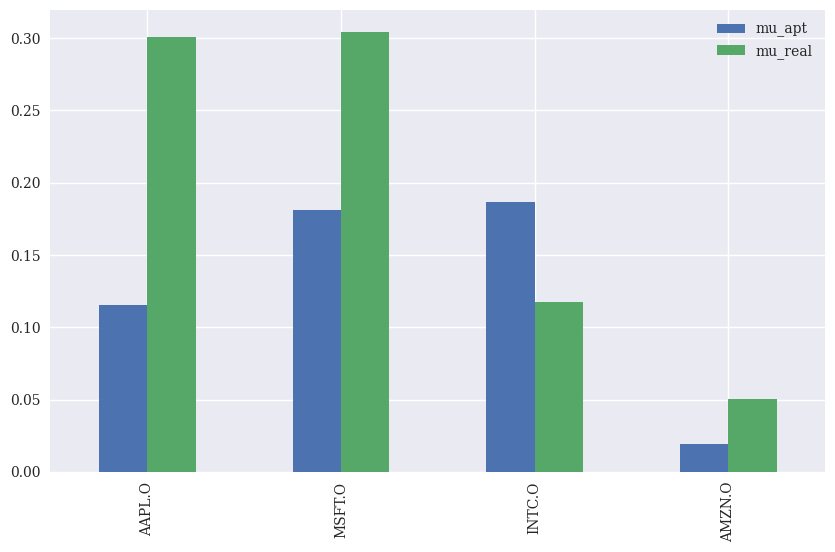

In [15]:
res = pd.DataFrame()
np.set_printoptions(formatter={"float": lambda x: f"{x:5.2f}"})

split = int(len(retsf) * 0.5) # 데이트를 반으로 나누기, retsf = 시계열에 대해 로그 수익률

for sym in rets.columns[:4]: # (['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O']
    print("\n" + sym)
    print(74 * "=")
    retsf_, retsd_ = retsf.iloc[:split], retsd.iloc[:split] # 첫번째 절반의 데이터
    reg = np.linalg.lstsq(retsf_, retsd_[sym], rcond=-1)[0] # factor 변화로 주식 수익률 변화 예측
    retsf_, retsd_ = retsf.iloc[split:], retsd.iloc[split:] # 두번째 절반의 데이터
    mu_apt = np.dot(retsf_.mean() * 252, reg) # 예측된 수익률
    mu_real = retsd_[sym].mean() * 252 # 실제 수익률
    res = pd.concat([res, pd.DataFrame({"symbol": sym, "mu_apt": mu_apt, "mu_real": mu_real},
                                       index=[sym])], sort=True)
    print("fl: {} | apt: {:.3f} | real: {:.3f}".format(reg.round(1), mu_apt, mu_real))
    
res.plot(kind="bar", figsize=(10,6))

추가 테스트를 통해 차익거래 가격결정 모형의 설명력을 좀 더 명확히 알아보자.
- 요인계수를 사용하여 차익거래 가격결정 모형이 시간 경과에 따른 주가 변동을 정확하게 설명할 수 있는지의 여부를 테스트 한다.
- 실제로 차익거래 가격결정 모형은 절대실적을 정확하게 예측하지는 못하지만 대부분은 주가 이동방향을 정확하게 예측한다.
- 기대 수익률과 실현 수익률 사이의 상관관계도 약 85%로 매우 높다.

** 분석에서는 실현요인 수익률을 사용하여 APT 예측을 생성하는데, 이 예측은 관련 거래일 하루 전에는 실제로 사용할 수 없다.

AMZN.O
연율화 수익률:
 AMZN.O_apt     0.019401
AMZN.O_real    0.050344
dtype: float64
연율화 변동성:
 AMZN.O_apt     0.270995
AMZN.O_real    0.307653
dtype: float64
             AMZN.O_apt  AMZN.O_real
AMZN.O_apt     1.000000     0.832218
AMZN.O_real    0.832218     1.000000


<Axes: xlabel='Date'>

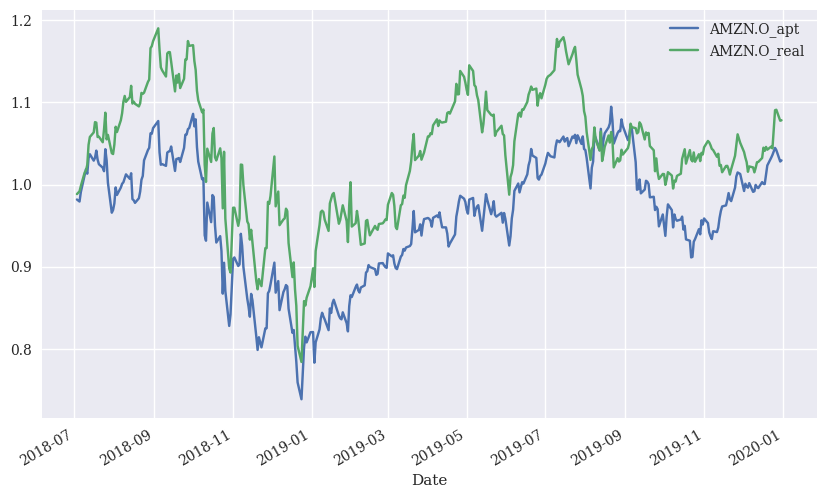

In [28]:
print(sym)

# factor와 regression coefficients를 사용하여 일간 주식 수익률을 예측
rets_sym = np.dot(retsf_, reg) # retsf_: factors, regs: regression coefficients

# 데이터프레임에 결과를 저장하고 컬럼 및 인덱스 데이터를 추가
rets_sym = pd.DataFrame(rets_sym, columns=[sym+"_apt"], index=retsf_.index)

# 실현주식 수익률을 데이터프레임에 추가
rets_sym[sym+"_real"] = retsd_[sym]

# 연율화 수익률 계산
print("연율화 수익률:\n",rets_sym.mean() * 252)

# 연율화 변동성 계산
print("연율화 변동성:\n", rets_sym.std() * 252 ** 0.5)

# 상관계수 계산
print(rets_sym.corr())

rets_sym.cumsum().apply(np.exp).plot(figsize=(10,6))

- 실현요인 수익률이 주어졌을때 주가의 방향을 예측.
  - 다음의 파이썬 코드는 75% 이상의 정확도를 보여준다.

In [31]:
rets_sym["same"] = (np.sign(rets_sym[sym + "_apt"]) == 
                    np.sign(rets_sym[sym + "_real"]))
print(rets_sym["same"].value_counts())
print(rets_sym["same"].value_counts()[True] / len(rets_sym))

same
True     288
False     89
Name: count, dtype: int64
0.7639257294429708


In [18]:
retsd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 754 entries, 2017-01-03 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  754 non-null    float64
 1   MSFT.O  754 non-null    float64
 2   INTC.O  754 non-null    float64
 3   AMZN.O  754 non-null    float64
 4   GS.N    754 non-null    float64
 5   SPY     754 non-null    float64
 6   .SPX    754 non-null    float64
 7   .VIX    754 non-null    float64
 8   EUR=    754 non-null    float64
 9   XAU=    754 non-null    float64
 10  GDX     754 non-null    float64
 11  GLD     754 non-null    float64
dtypes: float64(12)
memory usage: 76.6 KB
